## PROJEKT WALIDACYJNY - MICHAŁ BINDA MIKOŁAJ MRÓZ

## Splitting the database

In [1]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from statistics import mean
from langdetect import detect

df = pd.read_csv('PreProcessedData.csv', sep=',', names=['id','title','text','type'], header=None, skiprows=2,)
df.pop(df.columns[0])

0            1
1            2
2            3
3            4
4            5
         ...  
69039    69040
69040    69041
69041    69042
69042    69043
69043    69044
Name: id, Length: 69044, dtype: int64

In [3]:
train, test, validation = np.split(df, [int(len(df) * 0.6), int(len(df) * 0.8)])
train.head()


,title,text,type
0,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
1,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
2,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
3,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true
4,Here Is Why the Trump Administration Will Be a...,Originally appeared at The American Conservati...,fake


In [4]:
train = validation
train.head()

,title,text,type
55235,Obama On Baltimore: 'This Is Not New',President Barack Obama on Tuesday addressed th...,true
55236,Watch A Trump Supporter GO BONKERS Trying To ...,Anyone trying to defend Donald Trump after his...,fake
55237,LIBS ON TWITTER Go Nuts Over Kellyanne Conway’...,Liberals on Twitter just can t find enough rea...,fake
55238,Highlights: The Trump presidency on February 2...,(Reuters) - Highlights of the day for U.S. Pre...,true
55239,Malta police arrest 10 suspects in murder of b...,VALLETTA (Reuters) - Maltese police have arres...,true


### Lepszą opcją byłoby najpierw podzielenie danych pózniej dopiero usuwanie kolumn. W tej sytuacji kolejność nie ma znaczenia, ale lepiej trzymać się zasad

## Replacing NA and changing formats

In [5]:
# How many of them have either title na or text na and if any have both
print(len(train[train['title'].isna() | train['text'].isna()]))
print(len(train[train['title'].isna() & train['text'].isna()]))

154
0


In [6]:
# let's replace na values in title & text columns with an empty string
def replace_na(df):
    df['title'] =  df['title'].fillna('')
    df['text'] = df['text'].fillna('')
    df.loc[df['text'].str.isspace() | df['title'].str.isspace(), 'text'] = ''
    return df
    
replace_na(train)

,title,text,type
55235,Obama On Baltimore: 'This Is Not New',President Barack Obama on Tuesday addressed th...,true
55236,Watch A Trump Supporter GO BONKERS Trying To ...,Anyone trying to defend Donald Trump after his...,fake
55237,LIBS ON TWITTER Go Nuts Over Kellyanne Conway’...,Liberals on Twitter just can t find enough rea...,fake
55238,Highlights: The Trump presidency on February 2...,(Reuters) - Highlights of the day for U.S. Pre...,true
55239,Malta police arrest 10 suspects in murder of b...,VALLETTA (Reuters) - Maltese police have arres...,true
...,...,...,...
69039,Burundi opposition platform boycotts new round...,NAIROBI (Reuters) - Burundi s main opposition ...,true
69040,Hillary’s Message To Former Miss Universe Cal...,Miss Universe 1996 Alicia Machado is now an Am...,fake
69041,Cop Crashes Car And Runs Away When More Cops A...,The Daily Sheeple – by Ryan Banister \r\nAn aw...,fake
69042,Trump Stole An Idea From North Korean Propaga...,Jesus f*cking Christ our President* is a moron...,fake


### Zamienie NA wartości na puste stringi jest dobrym sposobem. Można by najpierw policzyć ile jest takich wierszy z wartościami NA, jeżeli jest to tylko kilka wierszy na 41 tysięcy, można takie wiersze usunąć. Jednak być może ten sposób lepiej sie przełoży na końcowy model. Polecam sprawdzić liczbe wierszy z wartosciami NA

Removing rows written in language different than English

In [7]:
def detect_language(row):
    try:
        return detect(row['title'])
    except:
        try:
            return detect(row['text'])
        except:
            return ''

def remove_other_languages(df):
    df['language'] = df.apply(lambda row: detect_language(row), axis=1)
    bad_rows_count = len(df[df['language'] != 'en'])
    print(f'There are', bad_rows_count, 'rows with a language different than English')
    df = df.drop(df[df.language != 'en'].index)
    df = df.drop('language', axis=1)
    return df

### usuwanie wierszy z tekstem w innym języku niz angielski - może te wiersze będą istotne w waszym modelu? Może by najpierw policzyc ile jest takich wierszy? jezeli ich jest bardzo mało to jak najbardziej można usunąć. Usuwanie wierszy bez większej wiedzy o nich nie jest najlepszym pomysłem.


In [8]:
train = remove_other_languages(train)
train.head()

There are 628 rows with a language different than English


,title,text,type
55235,Obama On Baltimore: 'This Is Not New',President Barack Obama on Tuesday addressed th...,true
55236,Watch A Trump Supporter GO BONKERS Trying To ...,Anyone trying to defend Donald Trump after his...,fake
55237,LIBS ON TWITTER Go Nuts Over Kellyanne Conway’...,Liberals on Twitter just can t find enough rea...,fake
55238,Highlights: The Trump presidency on February 2...,(Reuters) - Highlights of the day for U.S. Pre...,true
55239,Malta police arrest 10 suspects in murder of b...,VALLETTA (Reuters) - Maltese police have arres...,true


In [9]:
train['type'].unique()

array(['true', 'fake'], dtype=object)

### def change_type_format(df):
    df['type'] = (df['type']=='true').astype(int)
    return df

In [10]:
change_type_format(train)

NameError: name 'change_type_format' is not defined

## Generating additional columns

In [11]:
def count_capital_letters_part(title):
    capital_letters = 0
    c: str
    for c in title:
        if c.isupper():
            capital_letters += 1

    return capital_letters / len(title) if len(title) > 0 else 0

In [12]:
def count_punctuation_marks_per_char(text):
    if len(text) == 0:
        return 0
    return (text.count('?') +
            text.count('!') +
            text.count('.') +
            text.count(',') +
            text.count(':') +
            text.count('-') +
            text.count('"') +
            text.count(';')) / len(text)

In [13]:
def avg_word_length(text):
    words = text.split()

    if len(words) == 0:
        return 0

    return mean([len(word) for word in words])

In [14]:
reliable_sources = ['Reuters', 'CNN']
reliable_sources = [f'({x})' for x in reliable_sources]
spam_phrases = ['FOLLOW', 'CLICK', 'SUBSCRIBE', 'FREE']

### Bardzo ciekawy pomysł na stworzenie nowych kolumn, jak pozniej będzie widoczne na macierzy korelacji jest on bardzo udany  

In [15]:
def add_columns(df): 
    df['title_length'] = df['title'].str.len()
    df['capital_letters_part'] = df['title'].apply(count_capital_letters_part)
    df['trustworthy_source'] = (df['text'].str.contains('|'.join(reliable_sources), regex=True)).astype('int')
    df['link_count'] = df['text'].str.count('#') + df['text'].str.count('http') + df['text'].str.count('@')
    df['spam_phrases'] = df['text'].str.contains('|'.join(spam_phrases)).astype('int')
    df['punctuation_marks_per_char'] = df['text'].apply(count_punctuation_marks_per_char)
    df['avg_word_length'] = df['text'].apply(avg_word_length)
    return df[['title_length',
                'capital_letters_part', 
                'trustworthy_source', 
                'link_count', 
                'spam_phrases', 
                'punctuation_marks_per_char',
                'avg_word_length', 
                'type']]

In [16]:
train = add_columns(train)

/var/folders/qg/gflj6rgd0wj20kdyzmh7j73r0000gn/T/ipykernel_99689/1491959621.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['trustworthy_source'] = (df['text'].str.contains('|'.join(reliable_sources), regex=True)).astype('int')


array([[<AxesSubplot:title={'center':'title_length'}>,
        <AxesSubplot:title={'center':'capital_letters_part'}>,
        <AxesSubplot:title={'center':'trustworthy_source'}>],
       [<AxesSubplot:title={'center':'link_count'}>,
        <AxesSubplot:title={'center':'spam_phrases'}>,
        <AxesSubplot:title={'center':'punctuation_marks_per_char'}>],
       [<AxesSubplot:title={'center':'avg_word_length'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

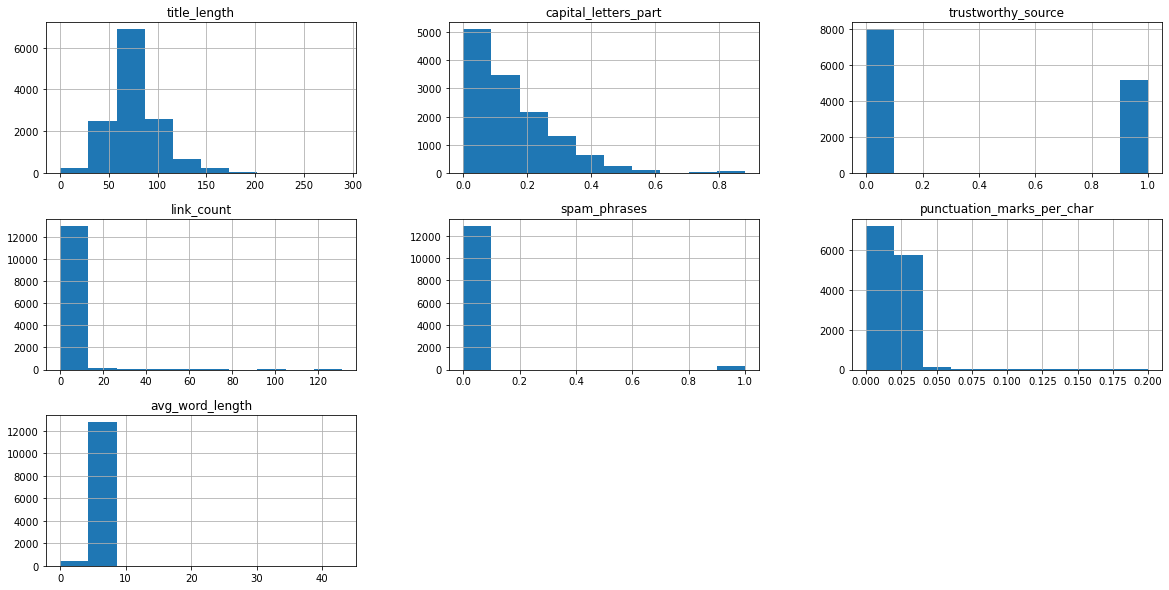

In [17]:
import matplotlib.pyplot as plt
train.hist(figsize=(20,10))

### Macierz korelacji na pliku walidacyjnym odbiega od macierzy na pliku treningowym, szczególnie dla kolumn "trustworthy_source". 

<AxesSubplot:>

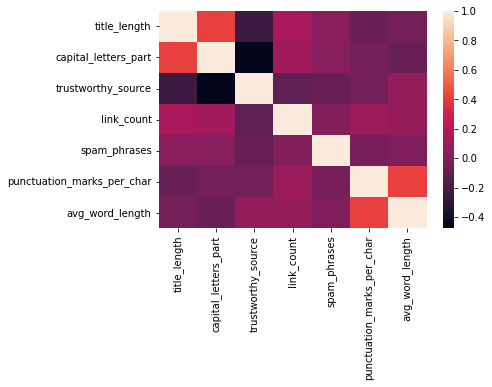

In [20]:
import seaborn as sns
sns.heatmap(train.corr())

### Nie skorzystaliscie tez z macierzy korelacji. Można usunąć jakies kolumny ktore maja bardzo słabą korelacje z kolumną "type". Oczywiście nie we wszystkich modelach jest to dobre podejście. Warto jednak sprawdzić czy usunięcie niektórych kolumn nie wpłynęlo by pozytywnie na predykcyjność modelu.

## Gini

In [26]:
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

## Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def standardize(df):
    df.loc[:, df.columns != "type"] = scaler.fit_transform(df.loc[:,df.columns != "type"].values)
    return df

In [ ]:
standardize(train)

### Preprocess function

In [24]:
def preprocess(df):
    df = replace_na(df)
    df = remove_other_languages(df)
    df = change_type_format(df)
    df = add_columns(df)
    df = standardize(df)
    return df